# RTM Example
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
    * true model
    * initial model
    * fwi model
1. Visualize the models 
1. Create list of shot locations 
1. Build a small local compute cluster (2 workers)
1. Build F, the distributed block operator for seismic modeling
1. Use F and generate "observed data" in the true model 
1. Use the Jacobian of F to migrate the observed data each model
1. Perform a little post migration filtering
1. Visualize Results

## Add required packages

In [16]:
using Distributed, PyPlot, Printf

## Read the models output from the FWI notebook

In [23]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"
file2 = "../50_fwi/marmousi_resampled_10m_349x1701_vinit.bin"
filef = "../50_fwi/marmousi_resampled_10m_349x1701_vfwi.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1 = read!(file1, Array{Float32}(undef,nz,nx));
v2 = read!(file2, Array{Float32}(undef,nz,nx));
vf = read!(filef, Array{Float32}(undef,nz,nx));

vmin,vmax = extrema(v1);
@show vmin,vmax;

(vmin, vmax) = (1377.2083f0, 4688.674f0)


## Visualize the models

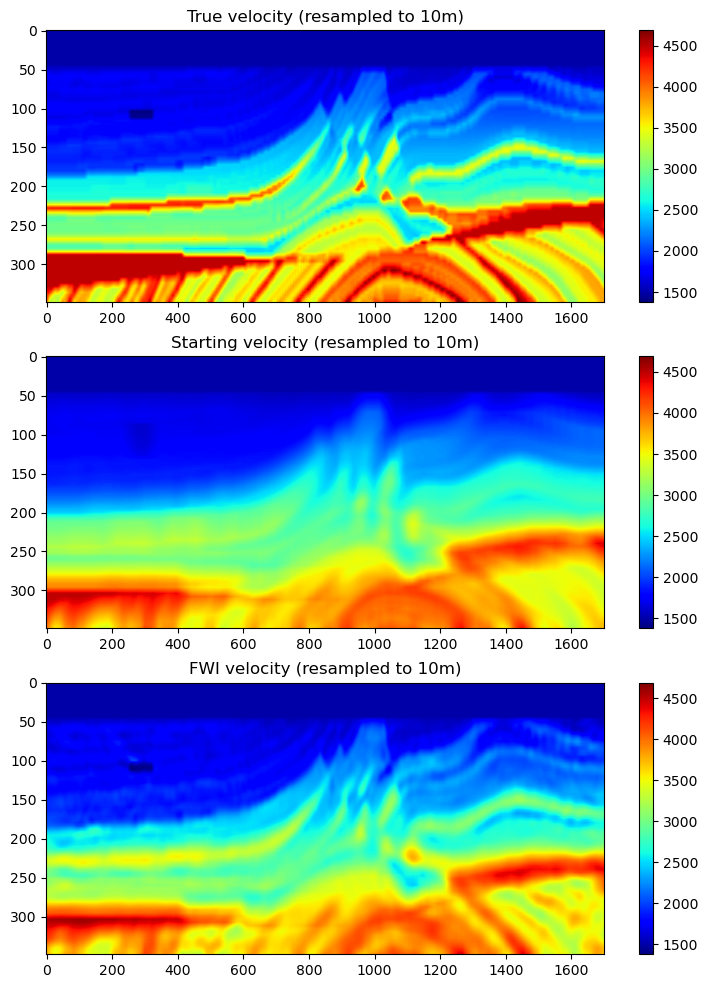

In [24]:
figure(figsize=(9,12)); clf()

subplot(3,1,1);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("True Velocity (resampled to 10m)")

subplot(3,1,2);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("Initial Velocity (resampled to 10m)");

subplot(3,1,3);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);
title("FWI Velocity (resampled to 10m)");

## 2. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster
Note we need to do this because we are using multiple workers on the same physical node, and without setting up thread affinity the modeling will be *incredibly* slow.

Because we set `ENV["OMP_DISPLAY_ENV"] = "true"`, when the "cluster spins up" by calling `addprocs()` below you will see the OMP environment printed out on each worker. You can verify that half of the threads are assigned to the first half of the physical cpus, and similarly for the second half, by looking at the value of the `OMP_PLACES` variable.

In [19]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [20]:
@everywhere using DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, Random


OPENMP DISPLAY ENVIRONMENT BEGIN
  _OPENMP = '201511'
  OMP_DYNAMIC = 'FALSE'
  OMP_NESTED = 'FALSE'
  OMP_NUM_THREADS = '22'
  OMP_SCHEDULE = 'DYNAMIC'
  OMP_PROC_BIND = 'CLOSE'
  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21},{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
  OMP_STACKSIZE = '0'
  OMP_WAIT_POLICY = 'PASSIVE'
  OMP_THREAD_LIMIT = '4294967295'
  OMP_MAX_ACTIVE_LEVELS = '2147483647'
  OMP_CANCELLATION = 'FALSE'
  OMP_DEFAULT_DEVICE = '0'
  OMP_MAX_TASK_PRIORITY = '0'
  OMP_DISPLAY_AFFINITY = 'FALSE'
  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
OPENMP DISPLAY ENVIRONMENT END


      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 3. Create list of shot locations 
We use 24 shot locations, twice as many as FWI, but we will run to significantly higher frequency. 

In [25]:
nshots = 24
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 24
sx = [0, 739, 1478, 2217, 2957, 3696, 4435, 5174, 5913, 6652, 7391, 8130, 8870, 9609, 10348, 11087, 11826, 12565, 13304, 14043, 14783, 15522, 16261, 17000]


## 4. Build F, the forward modeling operator

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [ ]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [ ]:
# Scale everything by a factor of 4 from the FWI example
@everywhere begin
    ntrec = 10001
    dtrec = 0.0010
    dtmod = 0.0005
end

@everywhere function makeF(i,nz,nx,dz,dx,sx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=16.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [ ]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sx) for i in I[1], j in I[2]], (nshots,1))

## Use F and generate "observed data" in the true model 

In [ ]:
d1 = F*v1

## Use the Jacobian of F to migrate the observed data each model
Note there is no water bottom mute or preprocessing applied here at all, those would clearly be improvements to this brute force workflow.

#### Migrate in the true velocity model

In [ ]:
t1 = @elapsed begin
    J1 = jacobian!(F, v1)
    illum1 = srcillum(J1)
    m1 = J1'*d1;
end
@show extrema(m1)
@show extrema(illum1)
@sprintf("Migrate time true model; %12.4f minutes\n", t1 / 60)

#### Migrate in the initial velocity model

In [ ]:
t2 = @elapsed begin
    J2 = jacobian!(F, v2)
    illum2 = srcillum(J2)
    m2 = J2'*d1;
end
@show extrema(m2)
@show extrema(illum2)
@sprintf("Migrate time init model; %12.4f minutes\n", t2 / 60)

#### Migrate in the FWI velocity model

In [ ]:
tf = @elapsed begin
    Jf = jacobian!(F, vf)
    illumf = srcillum(Jf)
    mf = Jf'*d1;
end
@show extrema(mf)
@show extrema(illumf)
@sprintf("Migrate time FWI  model; %12.4f minutes\n", tf / 60)

## Perform a little post migration filtering

#### Laplacian filter to remove backscattered noise

In [ ]:
L = JopLaplacian(JetSpace(Float32,nz,nx))

#### Apply low cut filter and illumination compenstation

In [ ]:
img1 = (L * m1) ./ (ill1 .+ 1e-8 * maximum(abs, ill1));
img2 = (L * m2) ./ (ill2 .+ 1e-8 * maximum(abs, ill1));
imgf = (L * mf) ./ (illf .+ 1e-8 * maximum(abs, ill1));

#### Apply gain

In [ ]:
g = ([0:(nz-1);]*dz).^2 * ones(1,nx);

## Visualize Results

In [ ]:
mmax = maximum(abs,m1)

figure(figsize=(9,12)); clf()

subplot(3,1,1);imshow(m1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(mmin,mmax);
title("Migration in True Velocity")

subplot(3,1,2);imshow(m2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(mmin,mmax);
title("Migration in Initial Velocity");

subplot(3,1,3);imshow(mf,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(mmin,mmax);
title("Migration in FWI Velocity");

## Remove local files and workers

In [ ]:
close(F)
rmprocs(workers())